In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import optuna
%matplotlib inline
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.models import load_model
import statsmodels.api as sm

c:\Users\Alexandre\anaconda3\envs\tf10\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Alexandre\AppData\Local\Temp\ipykernel_22004\82198243.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [3]:
def check_stationary(series):

    # Perform Augmented Dickey-Fuller Test
    adf_test = sm.tsa.adfuller(series)

    # Extract and print the test results
    adf_statistic = adf_test[0]
    p_value = adf_test[1]
    critical_values = adf_test[4]

    print("ADF Statistic:", adf_statistic)
    print("p-value:", p_value)
    print("Critical Values:", critical_values)

    # Interpret the results
    if p_value < 0.05:
        print("The time series is likely stationary (reject the null hypothesis)")
    else:
        print("The time series is likely non-stationary (fail to reject the null hypothesis)")

In [2]:
def merge_dfs(list_df):
    df = list_df[0]

    for i in range(1, len(list_df)):
        df = pd.merge(df, list_df[i], how='outer', on='date')

    df = df.fillna(df.mean())

    return df.sort_values(by='date').reset_index(drop=True)

In [50]:
cnt_join = pd.read_csv("series/count_join.csv")
max_hate = pd.read_csv("series/max_hate.csv")
sum_hate = pd.read_csv("series/sum_hate.csv")
avg_hate = pd.read_csv("series/avg_hate.csv")
max_news = pd.read_csv("series/max_news.csv")
sum_news = pd.read_csv("series/sum_news.csv")
avg_news = pd.read_csv("series/avg_news.csv")
cnt_news = pd.read_csv("series/cnt_news.csv")
per25_hate = pd.read_csv("series/per25_hate.csv")
per75_hate = pd.read_csv("series/per75_hate.csv")
per90_hate = pd.read_csv("series/per90_hate.csv")
per99_hate = pd.read_csv("series/per99_hate.csv")

In [52]:
merge_df = merge_dfs([cnt_join[['date', 'rate']], max_hate, sum_hate, avg_hate, max_news, sum_news, avg_news, cnt_news, per25_hate, per75_hate, per90_hate, per99_hate])

C:\Users\Alexandre\AppData\Local\Temp\ipykernel_22004\1584734230.py:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'per_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df, list_df[i], how='outer', on='date')
C:\Users\Alexandre\AppData\Local\Temp\ipykernel_22004\1584734230.py:7: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df.fillna(df.mean())


In [53]:
merge_df['timestamp'] = (pd.to_datetime(merge_df['date']) - pd.Timestamp("1970-01-01")) // pd.Timedelta(seconds=1)
merge_df['day_sin'] = np.sin(merge_df['timestamp'] * (2 * np.pi / (24*60*60)))

In [54]:
merge_df.drop(['date', 'timestamp'], axis=1, inplace=True)
merge_df

,rate,max_x,sum_x,avg_x,max_y,sum_y,avg_y,cnt,per_x,per_y,per_x,per_y,day_sin
0,28.485294,0.9907,92.8908,0.047956,458,799,266.333333,3,0.0003,0.008400,0.08182,0.918544,-8.652299e-12
1,23.651163,0.9950,51.2714,0.050414,589,1644,234.857143,7,0.0003,0.008300,0.07690,0.931924,-4.353760e-12
2,27.139241,0.9959,99.9323,0.046610,257,1099,137.375000,8,0.0003,0.007400,0.06691,0.920721,-5.522169e-14
3,35.594595,0.9975,49.3796,0.037494,282,887,98.555556,9,0.0002,0.005000,0.04176,0.824800,-1.030860e-11
4,29.492308,0.9928,81.8804,0.042713,143,769,69.909091,11,0.0002,0.007700,0.06026,0.887756,-6.010060e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,12.064171,0.9989,210.0204,0.093094,453,1223,61.150000,20,0.0004,0.026925,0.33510,0.965945,-1.472346e-12
480,15.239726,0.9989,177.5287,0.079788,789,3455,98.714286,35,0.0004,0.023700,0.24870,0.963940,-1.172572e-11
481,15.489655,0.9984,169.6245,0.075523,485,3382,86.717949,39,0.0004,0.020975,0.20610,0.951520,-7.427184e-12
482,11.074627,0.9988,222.3370,0.099882,521,2535,74.558824,34,0.0004,0.028800,0.38525,0.979975,-3.128646e-12


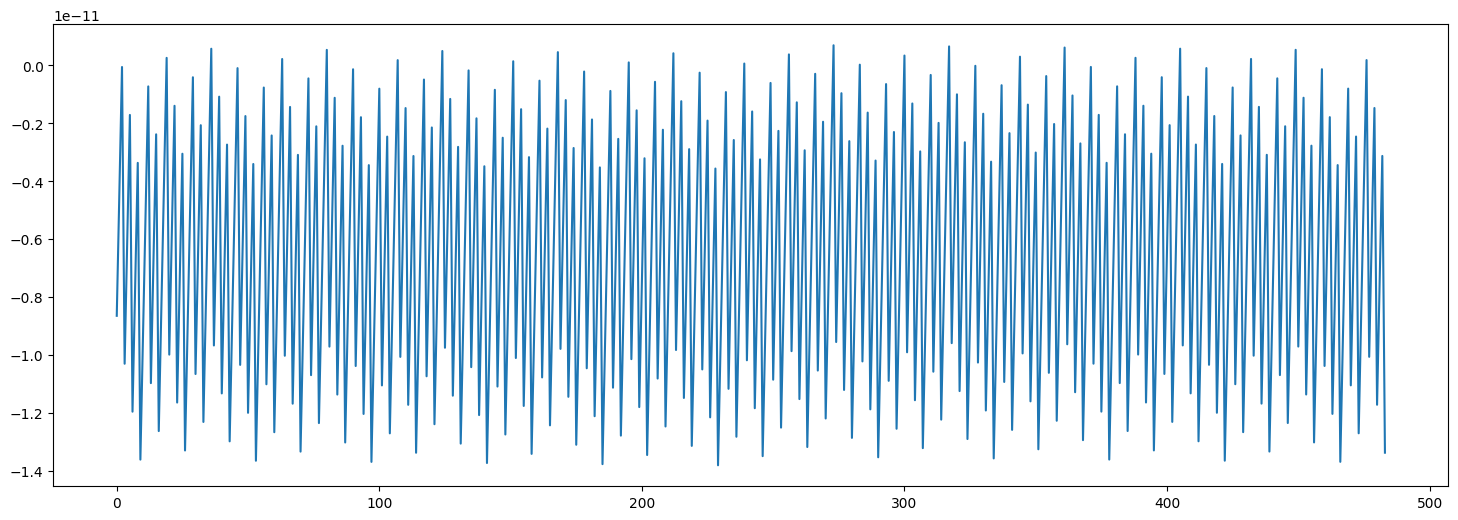

In [111]:
plt.figure(figsize=(18, 6))
plt.plot(merge_df['day_sin'])
plt.show()

In [9]:
check_stationary(cnt_join['rate'])
check_stationary(max_news['max'])
check_stationary(sum_news['sum'])
check_stationary(avg_news['avg'])
check_stationary(cnt_news['cnt'])

ADF Statistic: -2.2336056416127175
p-value: 0.19427535633216075
Critical Values: {'1%': -3.444310291143469, '5%': -2.867695986993458, '10%': -2.5700489042602586}
The time series is likely non-stationary (fail to reject the null hypothesis)
ADF Statistic: -4.22054632504077
p-value: 0.00060807470674292
Critical Values: {'1%': -3.444133731419755, '5%': -2.8676183066831036, '10%': -2.5700075029117166}
The time series is likely stationary (reject the null hypothesis)
ADF Statistic: -4.2822649098238985
p-value: 0.00047669613734356537
Critical Values: {'1%': -3.444162847239118, '5%': -2.8676311169658177, '10%': -2.5700143303792107}
The time series is likely stationary (reject the null hypothesis)
ADF Statistic: -3.86185827795749
p-value: 0.0023341873116884703
Critical Values: {'1%': -3.444133731419755, '5%': -2.8676183066831036, '10%': -2.5700075029117166}
The time series is likely stationary (reject the null hypothesis)
ADF Statistic: -3.641472962471575
p-value: 0.005015897242436088
Critical

In [10]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import plotly.express as px
import plotly.graph_objects as go

# Generate or load your multivariate time series data (replace with your actual data)
# Example data with two variables (var1 and var2)
data = pd.DataFrame({
    'max': max_news['max'],
    'sum': sum_news['sum'],
    'avg': avg_news['avg'],
    'cnt': cnt_news['cnt'],
})

# Split the data into training and testing sets (adjust as needed)
train_data = data.iloc[:-20, :]
test_data = data.iloc[-20:, :]

# Fit the VAR model
model = VAR(train_data)
model_fitted = model.fit()

# Check the optimal lag order (AIC criterion)
lag_order = model_fitted.k_ar
print("Optimal Lag Order:", lag_order)

# Forecast future values
forecast = model_fitted.forecast(train_data.values[-lag_order:], steps=len(test_data))

# Create a DataFrame for the forecasted values
forecast_df = pd.DataFrame(forecast, columns=train_data.columns)

fig = go.Figure()

# Add training data, actual test data, and forecasted data for var1
fig.add_trace(go.Scatter(x=train_data.index, y=train_data['max'], mode='lines', name='Training Data - max'))
fig.add_trace(go.Scatter(x=test_data.index, y=test_data['max'], mode='lines', name='Actual Test Data - max'))
fig.add_trace(go.Scatter(x=test_data.index, y=forecast_df['max'], mode='lines+markers', name='Forecasted Data - max'))

# Add training data, actual test data, and forecasted data for var2
fig.add_trace(go.Scatter(x=train_data.index, y=train_data['sum'], mode='lines', name='Training Data - sum'))
fig.add_trace(go.Scatter(x=test_data.index, y=test_data['sum'], mode='lines', name='Actual Test Data - sum'))
fig.add_trace(go.Scatter(x=test_data.index, y=forecast_df['sum'], mode='lines+markers', name='Forecasted Data - sum'))

# Add training data, actual test data, and forecasted data for var3
fig.add_trace(go.Scatter(x=train_data.index, y=train_data['avg'], mode='lines', name='Training Data - avg'))
fig.add_trace(go.Scatter(x=test_data.index, y=test_data['avg'], mode='lines', name='Actual Test Data - avg'))
fig.add_trace(go.Scatter(x=test_data.index, y=forecast_df['avg'], mode='lines+markers', name='Forecasted Data - avg'))

# Add training data, actual test data, and forecasted data for var4
fig.add_trace(go.Scatter(x=train_data.index, y=train_data['cnt'], mode='lines', name='Training Data - cnt'))
fig.add_trace(go.Scatter(x=test_data.index, y=test_data['cnt'], mode='lines', name='Actual Test Data - cnt'))
fig.add_trace(go.Scatter(x=test_data.index, y=forecast_df['cnt'], mode='lines+markers', name='Forecasted Data - cnt'))

# Customize the layout
fig.update_layout(
    title="VAR Forecasting",
    xaxis_title="Time",
    yaxis_title="Values",
    showlegend=True
)

# Show the interactive plot
fig.show()

Optimal Lag Order: 1


In [37]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [43]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go


# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merge_df)

# Define sequence length and forecasting horizon
sequence_length = 5
forecast_horizon = 1

# Create input-output pairs
X, y = [], []
for i in range(len(scaled_data) - sequence_length - forecast_horizon + 1):
    X.append(scaled_data[i:i+sequence_length])
    y.append(scaled_data[i+sequence_length:i+sequence_length+forecast_horizon])

X, y = np.array(X), np.array(y)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64))
model.add(tf.keras.layers.Dropout(0.5))
model.add(Dense(y_train.shape[2]))  # Output layer with one neuron per variable
# Compile the model
model.compile(optimizer='nadam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=2, verbose=1, validation_data=(X_val, y_val))

# Make predictions on the test data
predictions = model.predict(X_val)

# Inverse transform the scaled predictions and actual values
predicted_values = scaler.inverse_transform(predictions.reshape(-1, y_train.shape[2]))
actual_values = scaler.inverse_transform(y_val.reshape(-1, y_train.shape[2]))

# Calculate RMSE for each variable
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values, multioutput='raw_values'))


Epoch 1/10
192/192 [==============================] - 3s 8ms/step - loss: 0.0597 - val_loss: 0.0206
Epoch 2/10
192/192 [==============================] - 1s 6ms/step - loss: 0.0321 - val_loss: 0.0203
Epoch 3/10
192/192 [==============================] - 1s 6ms/step - loss: 0.0278 - val_loss: 0.0199
Epoch 4/10
192/192 [==============================] - 1s 5ms/step - loss: 0.0253 - val_loss: 0.0201
Epoch 5/10
192/192 [==============================] - 1s 6ms/step - loss: 0.0236 - val_loss: 0.0196
Epoch 6/10
192/192 [==============================] - 1s 6ms/step - loss: 0.0225 - val_loss: 0.0192
Epoch 7/10
192/192 [==============================] - 1s 6ms/step - loss: 0.0220 - val_loss: 0.0198
Epoch 8/10
192/192 [==============================] - 1s 6ms/step - loss: 0.0214 - val_loss: 0.0191
Epoch 9/10
192/192 [==============================] - 1s 6ms/step - loss: 0.0210 - val_loss: 0.0192
Epoch 10/10
192/192 [==============================] - 1s 6ms/step - loss: 0.0206 - val_loss: 0.0189

In [51]:
merge_df = merge_dfs([
    cnt_join[['date', 'rate']], 
    max_hate, 
    sum_hate, 
    avg_hate, 
    max_news,
    sum_news, 
    avg_news, 
    cnt_news, 
    per25_hate, 
    per75_hate, 
    per90_hate, 
    per99_hate
    ])

merge_df.drop(['date'], axis=1, inplace=True)

merge_df['timestamp'] = (pd.to_datetime(merge_df['date']) - pd.Timestamp("1970-01-01")) // pd.Timedelta(seconds=1)
merge_df['day_sin'] = np.sin(merge_df['timestamp'] * (2 * np.pi / (24*60*60)))
merge_df.drop(['date', 'timestamp'], axis=1, inplace=True)

C:\Users\Alexandre\AppData\Local\Temp\ipykernel_22004\1584734230.py:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'per_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df, list_df[i], how='outer', on='date')
C:\Users\Alexandre\AppData\Local\Temp\ipykernel_22004\1584734230.py:7: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df.fillna(df.mean())


KeyError: 'date'

In [55]:
merge_df

,rate,max_x,sum_x,avg_x,max_y,sum_y,avg_y,cnt,per_x,per_y,per_x,per_y,day_sin
0,28.485294,0.9907,92.8908,0.047956,458,799,266.333333,3,0.0003,0.008400,0.08182,0.918544,-8.652299e-12
1,23.651163,0.9950,51.2714,0.050414,589,1644,234.857143,7,0.0003,0.008300,0.07690,0.931924,-4.353760e-12
2,27.139241,0.9959,99.9323,0.046610,257,1099,137.375000,8,0.0003,0.007400,0.06691,0.920721,-5.522169e-14
3,35.594595,0.9975,49.3796,0.037494,282,887,98.555556,9,0.0002,0.005000,0.04176,0.824800,-1.030860e-11
4,29.492308,0.9928,81.8804,0.042713,143,769,69.909091,11,0.0002,0.007700,0.06026,0.887756,-6.010060e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,12.064171,0.9989,210.0204,0.093094,453,1223,61.150000,20,0.0004,0.026925,0.33510,0.965945,-1.472346e-12
480,15.239726,0.9989,177.5287,0.079788,789,3455,98.714286,35,0.0004,0.023700,0.24870,0.963940,-1.172572e-11
481,15.489655,0.9984,169.6245,0.075523,485,3382,86.717949,39,0.0004,0.020975,0.20610,0.951520,-7.427184e-12
482,11.074627,0.9988,222.3370,0.099882,521,2535,74.558824,34,0.0004,0.028800,0.38525,0.979975,-3.128646e-12


In [56]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merge_df)

# Define sequence length and forecasting horizon
sequence_length = 5
forecast_horizon = 1

# Create input-output pairs
X, y = [], []
for i in range(len(scaled_data) - sequence_length - forecast_horizon + 1):
    X.append(scaled_data[i:i+sequence_length])
    y.append(scaled_data[i+sequence_length:i+sequence_length+forecast_horizon])

X, y = np.array(X), np.array(y)

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [100]:
import optuna
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense

# Define a simple multivariate LSTM model using Keras
def create_model(input_dim, hidden_dim, num_layers, dropout_sug):
    model = keras.Sequential()
    for _ in range(num_layers):
        model.add(LSTM(hidden_dim, return_sequences=True))
    model.add(LSTM(hidden_dim))
    model.add(Dropout(dropout_sug))
    model.add(Dense(1))
    return model

# Hyperparameter optimization objective function
def objective(trial):
    # Define hyperparameters to optimize
    hidden_dim = trial.suggest_int('hidden_dim', 32, 128)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    dropout_sug = trial.suggest_float('dropout_sug', 0.0, 0.5)
    batch_sug = trial.suggest_categorical('batch_sug', [1, 4, 8, 16])
    sequencce_sug = trial.suggest_categorical('sequencce_sug', [3, 5, 10, 15])

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(merge_df)

    # Define sequence length and forecasting horizon
    sequence_length = sequencce_sug
    forecast_horizon = 1

    # Create input-output pairs
    X, y = [], []
    for i in range(len(scaled_data) - sequence_length - forecast_horizon + 1):
        X.append(scaled_data[i:i+sequence_length])
        y.append(scaled_data[i+sequence_length:i+sequence_length+forecast_horizon])

    X, y = np.array(X), np.array(y)
    
    # Create the Keras model
    model = create_model(input_dim=5, hidden_dim=hidden_dim, num_layers=num_layers, dropout_sug=dropout_sug)
    
    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mean_squared_error'
    )
    
    # Training loop
    history = model.fit(X_train, y_train, epochs=30, batch_size=batch_sug, validation_data=(X_val, y_val), verbose=0)
    
    # Get the final validation loss
    val_loss = history.history['val_loss'][-1]
    
    return val_loss

# Create an Optuna study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get the best hyperparameters and value
best_params = study.best_params
best_value = study.best_value
print("Best hyperparameters:", best_params)
print("Best validation loss:", best_value)


[I 2023-10-16 15:07:09,499] A new study created in memory with name: no-name-708e1214-c7f8-4a36-aabb-4e0c7e0d41c7
[I 2023-10-16 15:07:21,155] Trial 0 finished with value: 0.10247834771871567 and parameters: {'hidden_dim': 37, 'num_layers': 3, 'learning_rate': 0.0006928960773535914, 'dropout_sug': 0.2908990281319714, 'batch_sug': 16, 'sequencce_sug': 5}. Best is trial 0 with value: 0.10247834771871567.
[I 2023-10-16 15:08:24,349] Trial 1 finished with value: 0.10343349725008011 and parameters: {'hidden_dim': 33, 'num_layers': 2, 'learning_rate': 0.06275241221625424, 'dropout_sug': 0.1782725879412168, 'batch_sug': 1, 'sequencce_sug': 10}. Best is trial 0 with value: 0.10247834771871567.
[I 2023-10-16 15:08:41,592] Trial 2 finished with value: 0.10267162322998047 and parameters: {'hidden_dim': 126, 'num_layers': 3, 'learning_rate': 1.0761823093884455e-05, 'dropout_sug': 0.2654830880031387, 'batch_sug': 8, 'sequencce_sug': 10}. Best is trial 0 with value: 0.10247834771871567.
[I 2023-10-16

Best hyperparameters: {'hidden_dim': 109, 'num_layers': 1, 'learning_rate': 0.0043563040970433274, 'dropout_sug': 0.20872366312336352, 'batch_sug': 1, 'sequencce_sug': 15}
Best validation loss: 0.10047900676727295


In [101]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merge_df)

# Define sequence length and forecasting horizon
sequence_length = 15
forecast_horizon = 1

# Create input-output pairs
X, y = [], []
for i in range(len(scaled_data) - sequence_length - forecast_horizon + 1):
    X.append(scaled_data[i:i+sequence_length])
    y.append(scaled_data[i+sequence_length:i+sequence_length+forecast_horizon])

X, y = np.array(X), np.array(y)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=109, return_sequences=True))
model.add(LSTM(units=109))
model.add(tf.keras.layers.Dropout(0.20872366312336352))
model.add(Dense(y_train.shape[2]))  # Output layer with one neuron per variable
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0043563040970433274), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, validation_data=(X_val, y_val))

# Make predictions on the test data
predictions = model.predict(X_val)

# Inverse transform the scaled predictions and actual values
predicted_values = scaler.inverse_transform(predictions.reshape(-1, y_train.shape[2]))
actual_values = scaler.inverse_transform(y_val.reshape(-1, y_train.shape[2]))

# Calculate RMSE for each variable
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values, multioutput='raw_values'))


Epoch 1/200
375/375 [==============================] - 4s 7ms/step - loss: 0.0243 - val_loss: 0.0167
Epoch 2/200
375/375 [==============================] - 2s 5ms/step - loss: 0.0164 - val_loss: 0.0153
Epoch 3/200
375/375 [==============================] - 2s 5ms/step - loss: 0.0153 - val_loss: 0.0178
Epoch 4/200
375/375 [==============================] - 2s 6ms/step - loss: 0.0141 - val_loss: 0.0187
Epoch 5/200
375/375 [==============================] - 2s 6ms/step - loss: 0.0140 - val_loss: 0.0136
Epoch 6/200
375/375 [==============================] - 2s 5ms/step - loss: 0.0135 - val_loss: 0.0134
Epoch 7/200
375/375 [==============================] - 2s 5ms/step - loss: 0.0114 - val_loss: 0.0148
Epoch 8/200
375/375 [==============================] - 2s 6ms/step - loss: 0.0112 - val_loss: 0.0116
Epoch 9/200
375/375 [==============================] - 2s 6ms/step - loss: 0.0101 - val_loss: 0.0102
Epoch 10/200
375/375 [==============================] - 2s 6ms/step - loss: 0.0106 - val_lo

In [102]:
# Print RMSE for each variable
for i, var_name in enumerate(merge_df.columns):
    print(f"RMSE for {var_name}: {rmse[i]}")

RMSE for rate: 3.082674348285193
RMSE for max_x: 0.005573600978842607
RMSE for sum_x: 28.71621872232696
RMSE for avg_x: 0.009375404599573142
RMSE for max_y: 3313.7853191142517
RMSE for sum_y: 40993.87891912775
RMSE for avg_y: 157.10483724766536
RMSE for cnt: 41.42875563678147
RMSE for per_x: 3.804515533027907e-05
RMSE for per_y: 0.005818678549876156
RMSE for per_x: 0.06037159336117987
RMSE for per_y: 0.0190547741301352
RMSE for day_sin: 3.841447263918977e-12


In [103]:
predictions = model.predict(X_test)

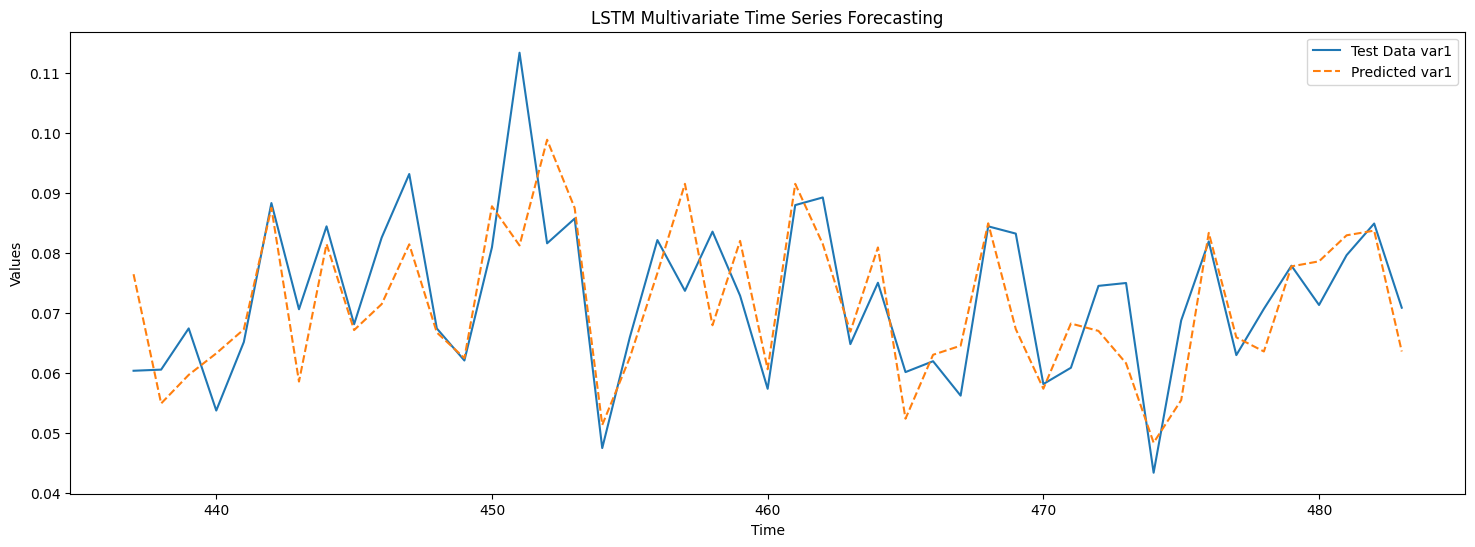

In [110]:
scaled_data_inverse = scaler.inverse_transform(scaled_data)

index = 3

# Plot the entire series, training, testing, and predicted data
plt.figure(figsize=(18, 6))
#plt.plot(scaled_data_inverse[:scaled_data_inverse.shape[0]-len(y_test), index], label='Actual var1')
plt.plot(np.arange(len(scaled_data_inverse) - len(y_test), len(scaled_data_inverse)), actual_values[:, index], label='Test Data var1')
plt.plot(np.arange(len(scaled_data_inverse) - len(y_test), len(scaled_data_inverse)), predicted_values[:, index], label='Predicted var1', linestyle='--')


plt.legend()
plt.title("LSTM Multivariate Time Series Forecasting")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

In [ ]:
model.save('model.h5')